In [1]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance")
from src.s3 import list_files_in_bucket, filter_files_by_pattern, read_parquet_from_s3
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from src.gtfs_segments import GTFS_shape_processor
from src.speeds import BusSpeedCalculator
from src.api import parse_zipped_gtfs
import geopandas as gpd
from src.api import query_feed_data, get_access_token
ACCESS_TOKEN = get_access_token()
pd.set_option('display.max_columns', None)


In [2]:
prefix = "norm/bus-mta-vp/vehicles/"

In [3]:
def load_all_parquet_files(file_list, bucket="dataclinic-gtfs-rt", max_workers=100):
    dfs = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(read_parquet_from_s3, bucket, key) for key in file_list]
        for future in as_completed(futures):
            try:
                dfs.append(future.result())
            except Exception as e:
                print(f"Error reading a file: {e}")
    return pd.concat(dfs, ignore_index=True)

## Step 0: Figure out which static feed is correct.

Pretty annoying. The trips and shapes are defined in the static gtfs feeds, and everytime a new static feed is released, the old `trip_id` values become obsolete. This is unfortunate because . It should be possible to just load all of the relevant static feeds and run a quick check on the relevant realtime feed data to see which static feed is in correct for the given dates. However, we can also just look through the outputs from MobilityData's API and find the one we want. Below, I load all the feeds for Manhattan.

In [6]:
query_feed_data("mdb-513", ACCESS_TOKEN)
# https://mobilitydatabase.org/feeds/mdb-513

[{'id': 'mdb-513-202402080022',
  'feed_id': 'mdb-513',
  'hosted_url': 'https://files.mobilitydatabase.org/mdb-513/mdb-513-202402080022/mdb-513-202402080022.zip',
  'note': None,
  'downloaded_at': '2024-02-08T00:52:25.481924Z',
  'hash': '25ebc713eff01d5d5da7e6a877926d636152417153dc591ef0763fa0851b3819',
  'bounding_box': {'minimum_latitude': 40.701536,
   'maximum_latitude': 40.865316,
   'minimum_longitude': -74.018088,
   'maximum_longitude': -73.864375},
  'validation_report': None,
  'service_date_range_start': None,
  'service_date_range_end': None},
 {'id': 'mdb-513-202404010033',
  'feed_id': 'mdb-513',
  'hosted_url': 'https://files.mobilitydatabase.org/mdb-513/mdb-513-202404010033/mdb-513-202404010033.zip',
  'note': None,
  'downloaded_at': '2024-04-01T00:26:36.207481Z',
  'hash': '4e9fce8767c4fe3eb5f0529ea49d29270543d0563d7fbf0d8c4c0920b61a3fbf',
  'bounding_box': {'minimum_latitude': 40.701536,
   'maximum_latitude': 40.865316,
   'minimum_longitude': -74.018088,
   'max

Here's the file for early January:

In [25]:
url = "https://files.mobilitydatabase.org/mdb-513/mdb-513-202501020055/mdb-513-202501020055.zip"
jan_02_gtfs = parse_zipped_gtfs(url)

## Step 1: Process static feed shapes into geodataframe

In order to calculate bus speeds, we examine the position of the bus coordinates along their trip-specific shapes provided in the static file. The class `GTFS_shape_processor` performs the needed calculations and returns the gdf.

/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


<Axes: >

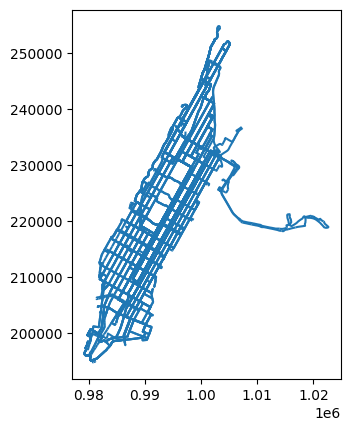

In [7]:
segment_df = GTFS_shape_processor(url, 4326, 2263).process_shapes()

segment_df.plot()

In [8]:
print(segment_df.head())
print(segment_df.columns)


                        trip_id shape_id  stop_sequence  stop_id  \
1  MQ_H5-Weekday-030000_M66_501  M660009              2   403503   
2  MQ_H5-Weekday-030000_M66_501  M660009              3   403504   
3  MQ_H5-Weekday-030000_M66_501  M660009              4   403505   
4  MQ_H5-Weekday-030000_M66_501  M660009              5   403506   
5  MQ_H5-Weekday-030000_M66_501  M660009              6   403508   

              stop_name  prev_stop_id        prev_stop_name  \
1          E 67 ST/1 AV        403997       E 67 ST/YORK AV   
2          E 67 ST/2 AV        403503          E 67 ST/1 AV   
3          E 67 ST/3 AV        403504          E 67 ST/2 AV   
4  E 67 ST/LEXINGTON AV        403505          E 67 ST/3 AV   
5    E 67 ST/MADISON AV        403506  E 67 ST/LEXINGTON AV   

   projected_position  prev_projected_position  segment_length  \
1          748.585596                 0.000000      748.585596   
2         1499.239158               748.585596      750.653562   
3         2021

## Step 2: Load relevant realtime data and calculate speeds:

First, we load the relevant realtime vehicle position data for January 6th, 2024 by identifying the correct files on the bucket and reading them into a dataframe.

In [10]:
daily_files_01_06 = list_files_in_bucket("dataclinic-gtfs-rt", prefix = f"{prefix}date=2025-01-06/")
vehicle_positions_01_06 = load_all_parquet_files(daily_files_01_06)

Then we just need to use the `BusSpeedCalculator` to combine the static shapes with the realtime positions and calculate the speeds along the route.

In [11]:
vehicle_positions_01_06.columns

Index(['id', 'time', 'trip.trip_id', 'trip.route_id', 'trip.direction_id',
       'trip.start_time', 'trip.start_date', 'trip.schedule_relationship',
       'trip.modified_trip.modifications_id',
       'trip.modified_trip.affected_trip_id', 'vehicle.id', 'vehicle.label',
       'vehicle.license_plate', 'vehicle.wheelchair_accessible',
       'position.latitude', 'position.longitude', 'position.bearing',
       'position.odometer', 'position.speed', 'current_stop_sequence',
       'stop_id', 'current_status', 'timestamp', 'congestion_level',
       'occupancy_status', 'occupancy_percentage', 'multi_carriage_details.id',
       'multi_carriage_details.label',
       'multi_carriage_details.occupancy_status',
       'multi_carriage_details.occupancy_percentage',
       'multi_carriage_details.carriage_sequence', 'date'],
      dtype='object')

In [22]:
GTFS_dict = parse_zipped_gtfs(url)
speed_calculator = BusSpeedCalculator(vehicle_positions_01_06, GTFS_dict, segment_df)

print(GTFS_dict.keys())
print(GTFS_dict["trips.txt"].columns)
print(GTFS_dict["trips.txt"].dtypes)
print(vehicle_positions_01_06.columns)
print(segment_df.columns)

dict_keys(['agency.txt', 'calendar.txt', 'calendar_dates.txt', 'routes.txt', 'shapes.txt', 'stops.txt', 'stop_times.txt', 'trips.txt'])
Index(['route_id', 'service_id', 'trip_id', 'trip_headsign', 'direction_id',
       'block_id', 'shape_id'],
      dtype='object')
route_id         object
service_id       object
trip_id          object
trip_headsign    object
direction_id      int64
block_id          int64
shape_id         object
dtype: object
Index(['id', 'time', 'trip.trip_id', 'trip.route_id', 'trip.direction_id',
       'trip.start_time', 'trip.start_date', 'trip.schedule_relationship',
       'trip.modified_trip.modifications_id',
       'trip.modified_trip.affected_trip_id', 'vehicle.id', 'vehicle.label',
       'vehicle.license_plate', 'vehicle.wheelchair_accessible',
       'position.latitude', 'position.longitude', 'position.bearing',
       'position.odometer', 'position.speed', 'current_stop_sequence',
       'stop_id', 'current_status', 'timestamp', 'congestion_level',
   

In [25]:
speeds = speed_calculator.create_trip_speeds()
speeds = speed_calculator.match_trip_with_route(speeds)

Processing 9755 trips...


100%|██████████| 9755/9755 [05:19<00:00, 30.52it/s]


In [34]:
print(speeds.columns)
print(speeds.head())
print(speeds.shape)

Index(['trip_id', 'shape_id', 'stop_sequence', 'stop_id', 'stop_name',
       'prev_stop_id', 'prev_stop_name', 'projected_position',
       'prev_projected_position', 'segment_length', 'interpolated_time',
       'time_elapsed', 'speed_mph', 'unique_trip_id', 'route_id', 'hour',
       'day', 'month', 'year', 'weekday'],
      dtype='object')
                        trip_id shape_id  stop_sequence  stop_id  \
0  MQ_A5-Weekday-008400_M42_301  M420009              3   403252   
1  MQ_A5-Weekday-008400_M42_301  M420009              4   403253   
2  MQ_A5-Weekday-008400_M42_301  M420009              5   904041   
3  MQ_A5-Weekday-008400_M42_301  M420009              6   403805   
4  MQ_A5-Weekday-008400_M42_301  M420009              7   403257   

            stop_name  prev_stop_id      prev_stop_name  projected_position  \
0        E 42 ST/2 AV        403251        E 42 ST/1 AV         1487.528547   
1        E 42 ST/3 AV        403252        E 42 ST/2 AV         2177.283022   
2   E 42

In [27]:
speeds["speed_mph"].describe()

count    222697.000000
mean          7.896888
std          11.733320
min           0.084497
25%           4.548137
50%           6.353812
75%           9.234023
max        1685.347126
Name: speed_mph, dtype: float64

<Axes: >

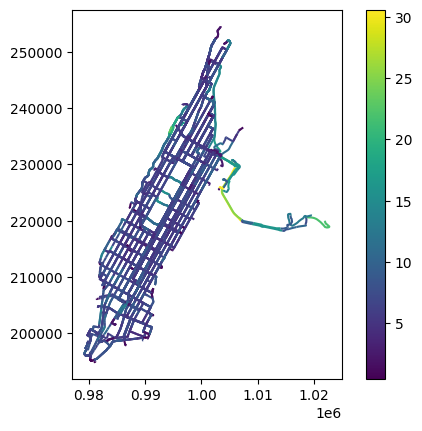

In [14]:
segment_df.merge(speeds.groupby(["prev_stop_id", "stop_id"])["speed_mph"].median().reset_index()).plot(column="speed_mph", legend=True)